In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
import pandas as pd
import numpy
import math
import time

from mpl_toolkits.mplot3d import Axes3D

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [6]:
n_samples = 500
input_dim = 50
d_H = 10
width = 1024  # 1024
bias = False
n_steps = 3000
base_lr = 5e-2
batch_size = 256

target_p = 2
SEED = 42
pause = 1e-6

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/high_dim/bias/{}'.format(width))

In [8]:
set_random_seeds(SEED)

## Data

In [9]:
# val data
X_val = torch.randn(size=(n_samples, input_dim), requires_grad=False)
all_Xs = torch.randn(size=(n_steps * batch_size, input_dim), requires_grad=False)

y_val = torch.norm(X_val[:, :d_H], p=target_p, dim=1, keepdim=True)
all_ys = torch.norm(all_Xs[:, :d_H], p=target_p, dim=1, keepdim=True)

In [10]:
network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network.train()
optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)

In [11]:
with torch.no_grad():
    b = network.input_layer.weight.detach()
    alphas = (torch.norm(b[:, :d_H], p=2, dim=1, keepdim=False) / 
              torch.norm(b, p=2, dim=1, keepdim=False)).detach().numpy()
    rs = torch.norm(b, p=2, dim=1, keepdim=False).detach().numpy()
    signs = torch.sign(network.output_layer.weight).detach().numpy().reshape(-1)
data = pd.DataFrame(columns=['alpha'], data=alphas)

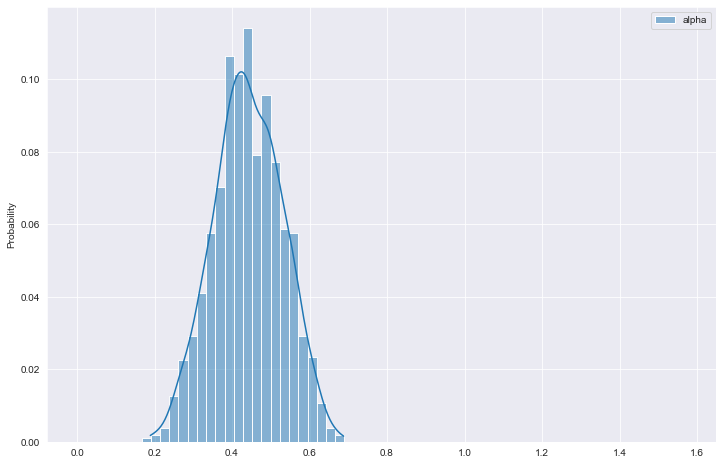

In [12]:
plt.figure(figsize=(12, 8))
sns.histplot(data=data, kde=True, stat='probability', binrange=(0., np.pi/2), label='t=0')
plt.show()

In [13]:
num = 30
alpha_grid = np.linspace(start=0., stop=1.0, num=num, endpoint=True)
e = torch.zeros((num, input_dim), requires_grad=False)
for i, alpha_val in enumerate(alpha_grid):
    e[i, 0] = alpha_val
    e[i, d_H] = np.sqrt(1 - alpha_val**2)

In [16]:
with torch.no_grad():
    residuals = (torch.norm(e[:, :d_H], p=target_p, dim=1, keepdim=True) - network.forward(e)).detach().numpy()
    residuals = residuals.reshape(-1)

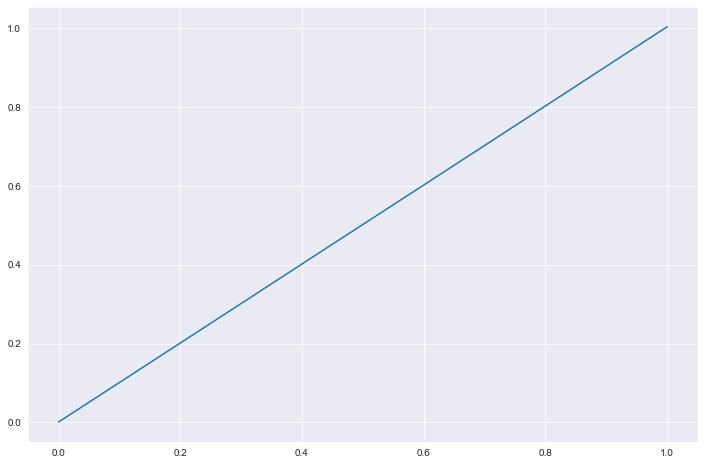

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(alpha_grid, residuals)
plt.show()

### Train

In [18]:
train_losses = []
val_losses = []
alphas = [alphas]
rs = [rs]
residuals = [residuals]

for i in range(n_steps):
    optimizer.zero_grad()
    X = all_Xs[i * batch_size: (i+1) * batch_size, :]
    y = all_ys[i * batch_size: (i+1) * batch_size, :]

    # forward
    y_hat = network.forward(X)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean()
        
    if i == 0:
        with torch.no_grad():
            loss_0 = loss_.detach().item()
    loss_ = loss_ / loss_0

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())

    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean() / loss_0
        val_losses.append(val_loss.detach().item())
        
        b = network.input_layer.weight.detach()
        b_norm_2 = b / torch.norm(b, p=2, dim=1, keepdim=True)
        b_norm_H = b[:, :d_H] / torch.norm(b[:, :d_H], p=2, dim=1, keepdim=True)

        alphas.append((torch.norm(b[:, :d_H], p=2, dim=1, keepdim=False) / 
                       torch.norm(b, p=2, dim=1, keepdim=False)).detach().numpy())
        rs.append(torch.norm(b, p=2, dim=1, keepdim=False).detach().numpy())
        
        residuals.append((torch.norm(e[:, :d_H], p=target_p, dim=1, keepdim=True) - 
                          network.forward(e)).detach().numpy().reshape(-1))
        
alphas = np.array(alphas)
rs = np.array(rs)

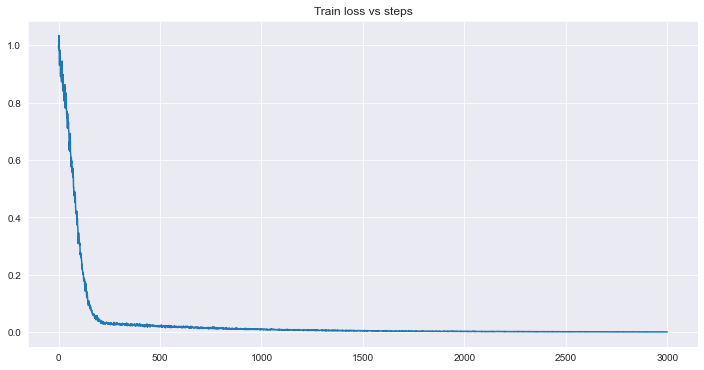

In [19]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train loss vs steps')
plt.show()

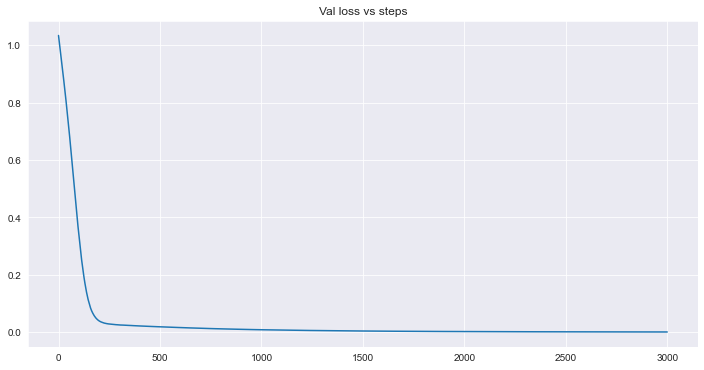

In [20]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Val loss vs steps')
plt.show()

### Post-training results

In [21]:
alphas_plus = alphas[:, signs > 0]
alphas_minus = alphas[:, signs < 0]

rs_plus = rs[:, signs > 0]
rs_minus = rs[:, signs < 0]

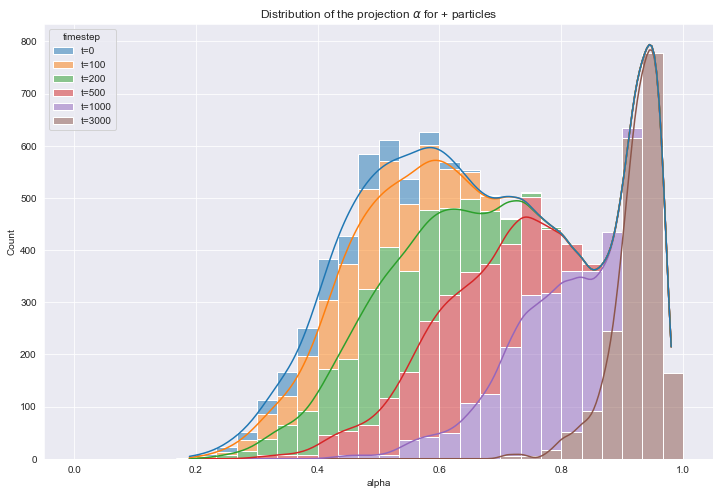

In [44]:
ts = [0, 100, 200, 500, 1000, 3000]
N = alphas_plus.shape[1]

data = pd.DataFrame(columns=['alpha', 'timestep', 'weight'])
data['alpha'] = alphas_plus[ts, :].reshape(-1)
data['weight'] = rs_plus[ts, :].reshape(-1)
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='alpha', hue='timestep', stat='count', kde=True, binrange=(0., 1), bins=30,
             multiple='stack', weights='weight')
plt.title('Distribution of the projection $\\alpha$ for + particles')
plt.show()

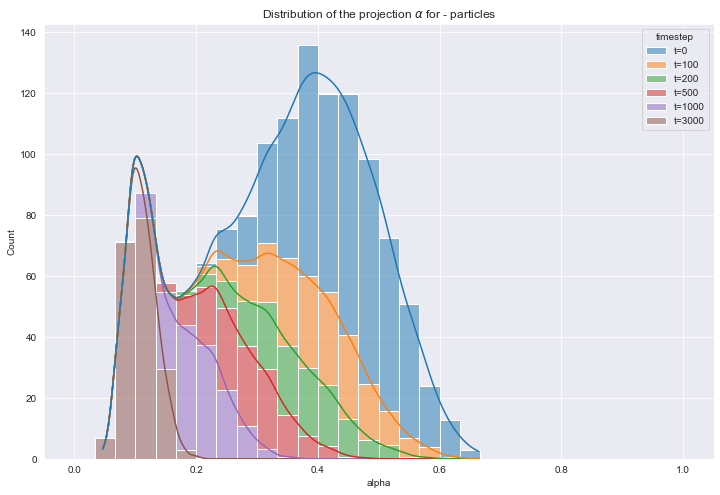

In [42]:
ts = [0, 100, 200, 500, 1000, 3000]
N = alphas_minus.shape[1]

data = pd.DataFrame(columns=['alpha', 'timestep', 'weight'])
data['alpha'] = alphas_minus[ts, :].reshape(-1)
data['weight'] = rs_minus[ts, :].reshape(-1)
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='alpha', hue='timestep', stat='count', kde=True, binrange=(0., 1), bins=30,
             multiple='stack', weights='weight')
plt.title('Distribution of the projection $\\alpha$ for - particles')
plt.show()

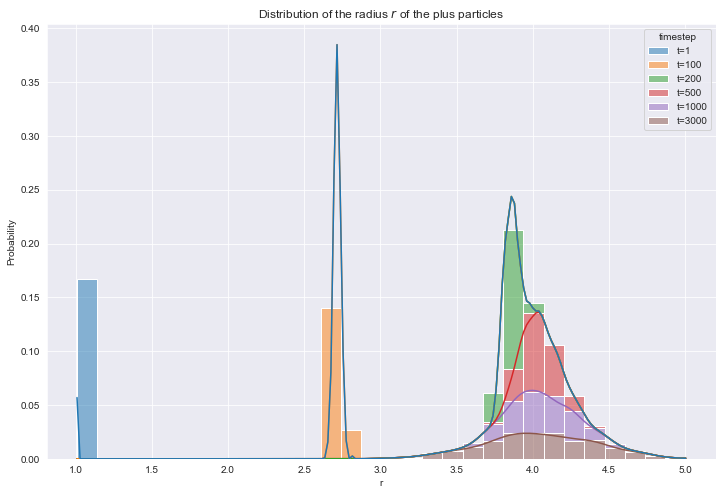

In [24]:
ts = [1, 100, 200, 500, 1000, 3000]
N = rs_plus.shape[1]

data = pd.DataFrame(columns=['r', 'timestep'])
data['r'] = rs_plus[ts, :].reshape(-1)
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='r', hue='timestep', stat='probability', kde=True, bins=30,
             multiple='stack')
plt.title('Distribution of the radius $r$ of the plus particles')
plt.show()

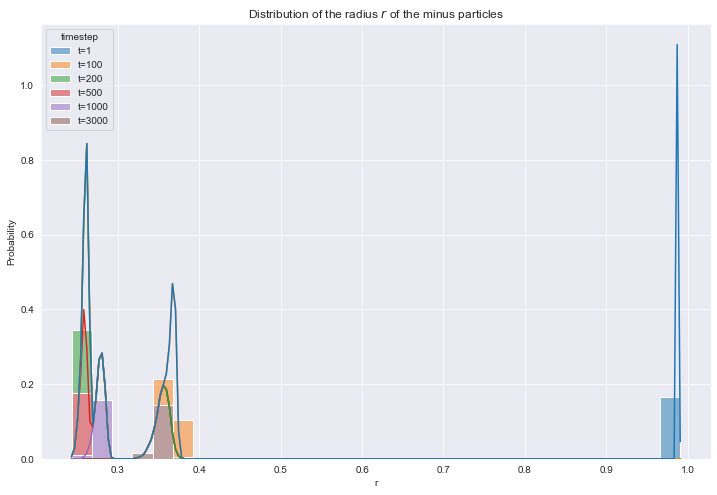

In [25]:
ts = [1, 100, 200, 500, 1000, 3000]
N = rs_minus.shape[1]

data = pd.DataFrame(columns=['r', 'timestep'])
data['r'] = rs_minus[ts, :].reshape(-1)
for i, t in enumerate(ts):
    data.loc[i * N: (i+1) * N, 'timestep'] = 't={}'.format(t)
    
plt.figure(figsize=(12, 8))
sns.histplot(data, x='r', hue='timestep', stat='probability', kde=True, bins=30,
             multiple='stack')
plt.title('Distribution of the radius $r$ of the minus particles')
plt.show()

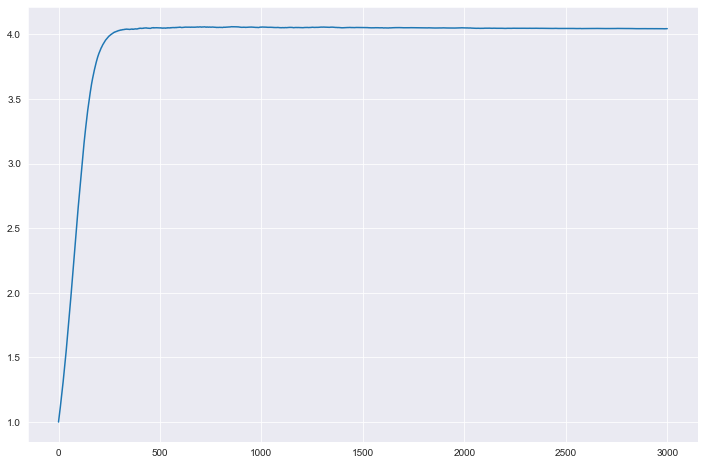

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(rs_plus)), rs_plus.mean(axis=1))
plt.show()

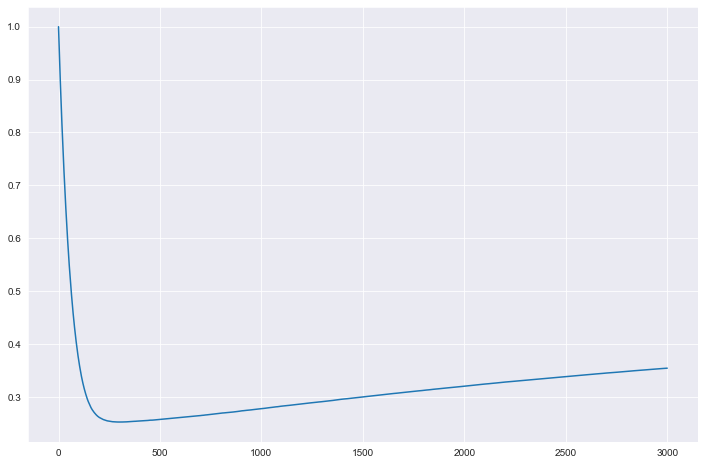

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(rs_plus)), rs_minus.mean(axis=1))
plt.show()

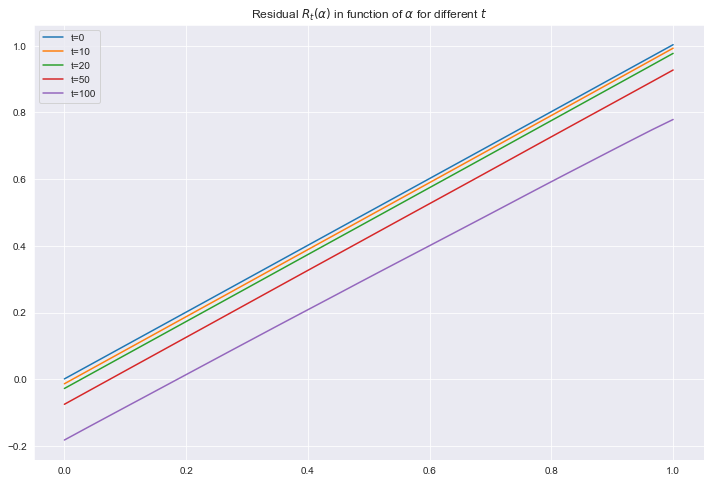

In [31]:
ts = [0, 10, 20, 50, 100]    
plt.figure(figsize=(12, 8))
for t in ts:
    plt.plot(alpha_grid, residuals[t], label='t={}'.format(t))
plt.legend()
plt.title('Residual $R_t(\\alpha)$ in function of $\\alpha$ for different $t$')
plt.show()

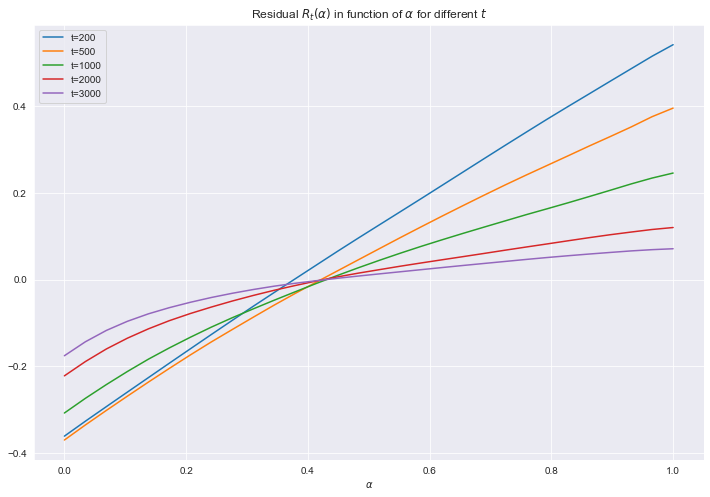

In [33]:
ts = [200, 500, 1000, 2000, 3000]    
plt.figure(figsize=(12, 8))
for t in ts:
    plt.plot(alpha_grid, residuals[t], label='t={}'.format(t))
plt.xlabel('$\\alpha$')
plt.legend()
plt.title('Residual $R_t(\\alpha)$ in function of $\\alpha$ for different $t$')
plt.show()